## Capstone Project Notebook 03/02/2026 Function 7 Week 2##
### 6D Optimization - The Absolute Ultimate Challenge!
### Goal: MAXIMIZE the objective function

In [20]:
# Section 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern
from scipy.stats import norm
from scipy.optimize import minimize

## Load Updated Dataset (Week 2)
F7 is **6D** - requires 1,000,000 points for basic grid coverage!

In [21]:
# Load the updated dataset
INPUT_FILE = 'f7_w2_inputs.npy'   # Shape (31, 6)
OUTPUT_FILE = 'f7_w2_outputs.npy' # Shape (31,)

In [22]:
X = np.load(INPUT_FILE)  # 6D inputs
Y = np.load(OUTPUT_FILE) # Outputs

In [23]:
# Display data summary
print(f"Input data shape: {X.shape}")
print(f"Output data shape: {Y.shape}")
print(f"\n6D Problem - THE ABSOLUTE ULTIMATE!")
print(f"Search space needs 1 MILLION points for grid coverage!")
print(f"Bayesian Optimization is the ONLY way!")

Input data shape: (31, 6)
Output data shape: (31,)

6D Problem - THE ABSOLUTE ULTIMATE!
Search space needs 1 MILLION points for grid coverage!
Bayesian Optimization is the ONLY way!


In [24]:
print(f"Loaded {X.shape[0]} points in {X.shape[1]}D (6D problem!)")
print(f"Current best (MAXIMUM): {Y.max():.6f} at {X[Y.argmax()]}")
print(f"Coverage: {X.shape[0]} / 1,000,000 = {100*X.shape[0]/1e6:.004f}%")
X = np.atleast_2d(X)
Y = Y.ravel()

Loaded 31 points in 6D (6D problem!)
Current best (MAXIMUM): 1.364968 at [0.05789554 0.49167222 0.24742222 0.21811844 0.42042833 0.73096984]
Coverage: 31 / 1,000,000 = 0.0031%


## Data Analysis

In [25]:
print("="*70)
print("F7 DATASET ANALYSIS (6D)")
print("="*70)
print(f"\nInput ranges:")
for i in range(6):
    print(f"  X{i+1}: [{X[:, i].min():.4f}, {X[:, i].max():.4f}]")

print(f"\nOutput statistics:")
print(f"  Best (maximum):  {Y.max():.6f}")
print(f"  Worst:           {Y.min():.6f}")
print(f"  Mean:            {Y.mean():.6f}")
print(f"  Median:          {np.median(Y):.6f}")
print(f"  Std:             {Y.std():.6f}")

# Find best point
best_idx = np.argmax(Y)
print(f"\n🎯 BEST POINT SO FAR:")
print(f"  Input:  X1={X[best_idx, 0]:.4f}, X2={X[best_idx, 1]:.4f}, X3={X[best_idx, 2]:.4f}")
print(f"          X4={X[best_idx, 3]:.4f}, X5={X[best_idx, 4]:.4f}, X6={X[best_idx, 5]:.4f}")
print(f"  Output: {Y[best_idx]:.6f}")

# Show top 10 points
sorted_indices = np.argsort(Y)[::-1]
print(f"\n📊 TOP 10 POINTS:")
for i in range(min(10, len(Y))):
    idx = sorted_indices[i]
    marker = "⭐" if idx == best_idx else "  "
    x_str = ', '.join([f'{x:.3f}' for x in X[idx]])
    print(f"{marker} {i+1:2d}. X=[{x_str}] → Y={Y[idx]:.4f}")

F7 DATASET ANALYSIS (6D)

Input ranges:
  X1: [0.0579, 0.9425]
  X2: [0.0118, 0.9247]
  X3: [0.0036, 0.9246]
  X4: [0.0737, 0.9610]
  X5: [0.0149, 0.9987]
  X6: [0.0511, 0.9510]

Output statistics:
  Best (maximum):  1.364968
  Worst:           0.002701
  Mean:            0.238604
  Median:          0.083747
  Std:             0.314904

🎯 BEST POINT SO FAR:
  Input:  X1=0.0579, X2=0.4917, X3=0.2474
          X4=0.2181, X5=0.4204, X6=0.7310
  Output: 1.364968

📊 TOP 10 POINTS:
⭐  1. X=[0.058, 0.492, 0.247, 0.218, 0.420, 0.731] → Y=1.3650
    2. X=[0.058, 0.396, 0.390, 0.513, 0.467, 0.485] → Y=0.8085
    3. X=[0.882, 0.204, 0.414, 0.420, 0.265, 0.731] → Y=0.6751
    4. X=[0.149, 0.034, 0.729, 0.316, 0.022, 0.517] → Y=0.6115
    5. X=[0.273, 0.324, 0.897, 0.833, 0.154, 0.796] → Y=0.6044
    6. X=[0.543, 0.925, 0.342, 0.646, 0.718, 0.343] → Y=0.5628
    7. X=[0.067, 0.528, 0.816, 0.961, 0.087, 0.778] → Y=0.5165
    8. X=[0.176, 0.624, 0.296, 0.470, 0.098, 0.728] → Y=0.4754
    9. X=[0.418,

## Section 2: Fit Gaussian Process Surrogate Model

In [26]:
# Kernel for 6D problem
kernel = ConstantKernel(1.0, constant_value_bounds=(1e-3, 1e3)) * \
         Matern(length_scale=0.5, length_scale_bounds=(0.01, 10.0), nu=2.5) + \
         WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-9, 1e-1))

In [27]:
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=30,
    normalize_y=True,
    random_state=42
)

In [28]:
# Fit the GP model
gp.fit(X, Y)
print(f"GP fitted. Learned kernel: {gp.kernel_}")

GP fitted. Learned kernel: 0.988**2 * Matern(length_scale=0.332, nu=2.5) + WhiteKernel(noise_level=2.35e-09)


## Section 3: Define Acquisition Functions
**Configured for MAXIMIZATION**

In [29]:
def expected_improvement(X_new, gp, y_best, xi=0.01):
    """EI for maximization"""
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-9)
    imp = mu - y_best - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-9] = 0.0
    return ei

def upper_confidence_bound(X_new, gp, kappa=2.0):
    """UCB for maximization"""
    mu, sigma = gp.predict(X_new, return_std=True)
    return mu + kappa * sigma

## Section 4: Optimize Acquisition Functions
Using MAXIMUM restarts for 6D!

In [30]:
# Define search bounds (6D)
bounds = [(0.0, 1.0)] * 6

# Current best value
y_best = Y.max()

print("="*70)
print("OPTIMIZING EXPECTED IMPROVEMENT (EI)")
print("="*70)

def neg_ei(x):
    return -expected_improvement(x.reshape(1, -1), gp, y_best, xi=0.01)[0]

best_ei = np.inf
x_next_ei = None

# MAXIMUM restarts for 6D!
for i in range(150):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ei, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ei:
        best_ei = result.fun
        x_next_ei = result.x

mu_ei, sigma_ei = gp.predict(x_next_ei.reshape(1, -1), return_std=True)

print(f"EI suggests:")
print(f"  X1={x_next_ei[0]:.6f}, X2={x_next_ei[1]:.6f}, X3={x_next_ei[2]:.6f}")
print(f"  X4={x_next_ei[3]:.6f}, X5={x_next_ei[4]:.6f}, X6={x_next_ei[5]:.6f}")
print(f"Predicted value: {mu_ei[0]:.6f} ± {sigma_ei[0]:.6f}")
print(f"Expected Improvement: {-best_ei:.6f}")

OPTIMIZING EXPECTED IMPROVEMENT (EI)
EI suggests:
  X1=0.016201, X2=0.437721, X3=0.301358
  X4=0.217887, X5=0.388359, X6=0.697756
Predicted value: 1.341773 ± 0.107893
Expected Improvement: 0.028467


In [31]:
print("\n" + "="*70)
print("OPTIMIZING UPPER CONFIDENCE BOUND (UCB)")
print("="*70)

kappa = 2.0

def neg_ucb(x):
    return -upper_confidence_bound(x.reshape(1, -1), gp, kappa)[0]

best_ucb = np.inf
x_next_ucb = None

for i in range(150):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ucb, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ucb:
        best_ucb = result.fun
        x_next_ucb = result.x

mu_ucb, sigma_ucb = gp.predict(x_next_ucb.reshape(1, -1), return_std=True)

print(f"UCB suggests:")
print(f"  X1={x_next_ucb[0]:.6f}, X2={x_next_ucb[1]:.6f}, X3={x_next_ucb[2]:.6f}")
print(f"  X4={x_next_ucb[3]:.6f}, X5={x_next_ucb[4]:.6f}, X6={x_next_ucb[5]:.6f}")
print(f"Predicted value: {mu_ucb[0]:.6f} ± {sigma_ucb[0]:.6f}")
print(f"UCB value: {-best_ucb:.6f}")


OPTIMIZING UPPER CONFIDENCE BOUND (UCB)
UCB suggests:
  X1=0.000000, X2=0.397089, X3=0.337613
  X4=0.206766, X5=0.368718, X6=0.693197
Predicted value: 1.263577 ± 0.160900
UCB value: 1.585377


## Section 5: Local Refinement Strategy

In [32]:
print("\n" + "="*70)
print("LOCAL REFINEMENT - Points near current best")
print("="*70)

best_idx = np.argmax(Y)
best_point = X[best_idx]

step_size = 0.05
local_points = []
for i in range(6):
    point_minus = best_point.copy()
    point_minus[i] -= step_size
    local_points.append(point_minus)
    
    point_plus = best_point.copy()
    point_plus[i] += step_size
    local_points.append(point_plus)

print(f"Current best: X=[{', '.join([f'{x:.4f}' for x in best_point])}]")
print(f"Value: {Y[best_idx]:.6f}\n")

best_local_pred = -np.inf
best_local_point = None
dim_names = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']

for i, lp in enumerate(local_points):
    if all(bounds[j][0] <= lp[j] <= bounds[j][1] for j in range(6)):
        mu, std = gp.predict(np.array(lp).reshape(1, -1), return_std=True)
        dim_idx = i // 2
        direction = '-' if i % 2 == 0 else '+'
        print(f"  {dim_names[dim_idx]}{direction}: {mu[0]:.4f} ± {std[0]:.4f}")
        
        if mu[0] > best_local_pred:
            best_local_pred = mu[0]
            best_local_point = lp

if best_local_point is not None:
    print(f"\nBest local: X=[{', '.join([f'{x:.6f}' for x in best_local_point])}]")
    print(f"Predicted: {best_local_pred:.6f}")


LOCAL REFINEMENT - Points near current best
Current best: X=[0.0579, 0.4917, 0.2474, 0.2181, 0.4204, 0.7310]
Value: 1.364968

  X1-: 1.3560 ± 0.0589
  X1+: 1.3281 ± 0.0583
  X2-: 1.3575 ± 0.0585
  X2+: 1.3284 ± 0.0585
  X3-: 1.3276 ± 0.0588
  X3+: 1.3586 ± 0.0585
  X4-: 1.3439 ± 0.0571
  X4+: 1.3414 ± 0.0551
  X5-: 1.3531 ± 0.0557
  X5+: 1.3264 ± 0.0560
  X6-: 1.3534 ± 0.0572
  X6+: 1.3341 ± 0.0582

Best local: X=[0.057896, 0.491672, 0.297422, 0.218118, 0.420428, 0.730970]
Predicted: 1.358640


## Section 6: Visualization

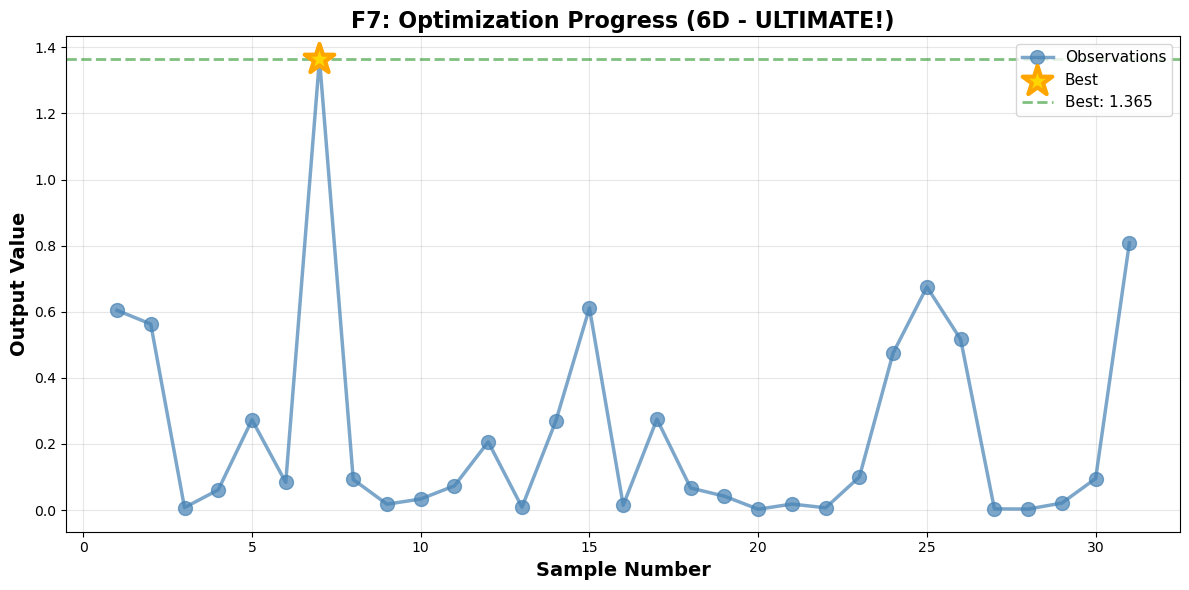

In [33]:
# Progress plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(range(1, len(Y)+1), Y, 'o-', linewidth=2.5, markersize=10, 
        color='steelblue', alpha=0.7, label='Observations')
ax.scatter(best_idx+1, Y[best_idx], c='gold', s=500, marker='*',
           edgecolors='orange', linewidth=3, label='Best', zorder=10)
ax.axhline(y=Y[best_idx], color='green', linestyle='--', linewidth=2,
           alpha=0.5, label=f'Best: {Y[best_idx]:.3f}')
ax.set_xlabel('Sample Number', fontsize=14, fontweight='bold')
ax.set_ylabel('Output Value', fontsize=14, fontweight='bold')
ax.set_title('F7: Optimization Progress (6D - ULTIMATE!)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 7: Final Recommendation

In [34]:
print("\n" + "="*70)
print("🎯 FINAL RECOMMENDATION FOR F7 WEEK 2")
print("="*70)

print("\nCurrent Status:")
print(f"  Best value: {Y[best_idx]:.6f}")
print(f"  Best point: X=[{', '.join([f'{x:.4f}' for x in X[best_idx]])}]")

print("\n⭐⭐⭐ RECOMMENDATION: Expected Improvement (EI)")
print(f"  Point: X=[{', '.join([f'{x:.6f}' for x in x_next_ei])}]")
print(f"  Predicted: {mu_ei[0]:.6f} ± {sigma_ei[0]:.6f}")
print(f"  WHY: BO is THE ONLY method that works in 6D!")

print("\n🥈 Alternative: UCB (More exploratory)")
print(f"  Point: X=[{', '.join([f'{x:.6f}' for x in x_next_ucb])}]")
print(f"  Predicted: {mu_ucb[0]:.6f} ± {sigma_ucb[0]:.6f}")

if best_local_point is not None:
    print("\n🥉 Alternative: Local Refinement (Conservative)")
    print(f"  Point: X=[{', '.join([f'{x:.6f}' for x in best_local_point])}]")
    print(f"  Predicted: {best_local_pred:.6f}")

print("\n" + "="*70)
print("6D: Without BO, this problem is literally impossible!")
print("="*70)


🎯 FINAL RECOMMENDATION FOR F7 WEEK 2

Current Status:
  Best value: 1.364968
  Best point: X=[0.0579, 0.4917, 0.2474, 0.2181, 0.4204, 0.7310]

⭐⭐⭐ RECOMMENDATION: Expected Improvement (EI)
  Point: X=[0.016201, 0.437721, 0.301358, 0.217887, 0.388359, 0.697756]
  Predicted: 1.341773 ± 0.107893
  WHY: BO is THE ONLY method that works in 6D!

🥈 Alternative: UCB (More exploratory)
  Point: X=[0.000000, 0.397089, 0.337613, 0.206766, 0.368718, 0.693197]
  Predicted: 1.263577 ± 0.160900

🥉 Alternative: Local Refinement (Conservative)
  Point: X=[0.057896, 0.491672, 0.297422, 0.218118, 0.420428, 0.730970]
  Predicted: 1.358640

6D: Without BO, this problem is literally impossible!


## Section 8: Format Output for Submission

In [35]:
USE_EI = True  # ABSOLUTELY ESSENTIAL for 6D!

if USE_EI:
    x_next = x_next_ei
    method_name = "Expected Improvement (EI)"
else:
    x_next = x_next_ucb
    method_name = "Upper Confidence Bound (UCB)"

print("\n" + "="*70)
print("QUERY SUBMISSION")
print("="*70)
print(f"Method: {method_name}")
print(f"Function 7 - Next point:")
print(f"  [{', '.join([f'{x:.6f}' for x in x_next])}]")
print("="*70)


QUERY SUBMISSION
Method: Expected Improvement (EI)
Function 7 - Next point:
  [0.016201, 0.437721, 0.301358, 0.217887, 0.388359, 0.697756]
